In [14]:
import re
from datetime import datetime

In [15]:
import os
import geopandas as gpd
import geemap
import xml.etree.ElementTree as ET
import pandas as pd
from shapely.geometry import LineString

# constante requerida
namespace = {"kml": "http://www.opengis.net/kml/2.2"}

In [16]:
import geopandas as gpd
from pyproj import CRS
from pykml import parser
from shapely.geometry import Point, LineString

In [26]:
# Directorio donde están los archivos KML
path_kml = r'G:/VUELOS_FUM/'
contenido = os.listdir(path_kml)
len(contenido)

75

In [27]:
path_kml

'G:/VUELOS_FUM/'

In [30]:
import geopandas as gpd
from pyproj import CRS
from pykml import parser
from shapely.geometry import LineString
import os

In [31]:
def convertir_kmls_a_shapefile(kml_folder, shapefile_path):
    """
    Convierte varios archivos KML en una carpeta a un solo shapefile con la proyección UTM zona 20S.

    Parámetros:
    kml_folder (str): Carpeta que contiene los archivos KML.
    shapefile_path (str): Ruta donde se guardará el archivo shapefile combinado.
    """
    line_geometries = []

    # Procesar cada archivo KML en la carpeta
    for filename in os.listdir(kml_folder):
        if filename.endswith('.kml'):
            kml_path = os.path.join(kml_folder, filename)
            
            # Leer el archivo KML
            with open(kml_path, 'r') as file:
                root = parser.parse(file).getroot()

            # Extraer coordenadas de Placemark y crear geometría LineString
            for placemark in root.Document.Placemark:
                coordinates = placemark.LineString.coordinates.text.strip().split()
                points = [tuple(map(float, coord.split(','))) for coord in coordinates]
                line_geometries.append(LineString(points))

    # Crear un GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=line_geometries, crs='EPSG:4326')

    # Definir el sistema de referencia de coordenadas de destino (UTM zona 20S)
    crs_utm_20s = CRS("EPSG:32720")

    # Transformar las coordenadas al sistema UTM zona 20S
    gdf_utm = gdf.to_crs(crs_utm_20s)

    # Guardar el GeoDataFrame como un shapefile
    gdf_utm.to_file(shapefile_path, driver='ESRI Shapefile')

    print(f"Archivo shapefile combinado guardado en: {shapefile_path}")




In [32]:
# Ejemplo de uso
kml_folder = r'G:/VUELOS_FUM/'
shapefile_path = r'G:/VUELOS_FUM_2/res.shp'
convertir_kmls_a_shapefile(kml_folder, shapefile_path)

Archivo shapefile combinado guardado en: G:/VUELOS_FUM_2/res.shp


In [29]:
j = 0
for i in contenido:
    # directorio + nombre de archivo
    path = path_kml + i
    #output_folder = "ruta/a/tu/carpeta"
    output_folder = r'G:/VUELOS_FUM_2/'
    shapefile_name = i
    convertir_kml_a_shapefile(path, output_folder, shapefile_name)
    j = j + 1
    print(shapefile_path)

G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132130_R0494334786.kml
G:/VUELOS_FUM_2/T40_20240517132

In [28]:
def convertir_kml_a_shapefile(kml_path, output_folder, shapefile_name):
    """
    Convierte un archivo KML a un shapefile con la proyección UTM zona 20S.

    Parámetros:
    kml_path (str): Ruta del archivo KML.
    output_folder (str): Carpeta donde se guardarán los archivos del shapefile.
    shapefile_name (str): Nombre base del archivo shapefile (sin extensión).
    """
    # Leer el archivo KML
    with open(kml_path, 'r') as file:
        root = parser.parse(file).getroot()

    # Extraer coordenadas de Placemark y crear geometría LineString
    line_geometries = []
    for placemark in root.Document.Placemark:
        coordinates = placemark.LineString.coordinates.text.strip().split()
        points = [tuple(map(float, coord.split(','))) for coord in coordinates]
        line_geometries.append(LineString(points))

    # Crear un GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=line_geometries, crs='EPSG:4326')

    # Definir el sistema de referencia de coordenadas de destino (UTM zona 20S)
    crs_utm_20s = CRS("EPSG:32720")

    # Transformar las coordenadas al sistema UTM zona 20S
    gdf_utm = gdf.to_crs(crs_utm_20s)

    # Asegurarse de que la carpeta de salida exista
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Construir la ruta completa para el shapefile
    shapefile_path = os.path.join(output_folder, shapefile_name)

    # Guardar el GeoDataFrame como un shapefile
    gdf_utm.to_file(shapefile_path, driver='ESRI Shapefile')

In [20]:
def convertir_kml_a_shapefile(kml_path, shapefile_path):
    """
    Convierte un archivo KML a un shapefile con la proyección UTM zona 20S.

    Parámetros:
    kml_path (str): Ruta del archivo KML.
    shapefile_path (str): Ruta donde se guardará el archivo shapefile.
    """
    # Leer el archivo KML
    with open(kml_path, 'r') as file:
        root = parser.parse(file).getroot()

    # Extraer coordenadas de Placemark y crear geometría LineString
    line_geometries = []
    for placemark in root.Document.Placemark:
        coordinates = placemark.LineString.coordinates.text.strip().split()
        points = [tuple(map(float, coord.split(','))) for coord in coordinates]
        line_geometries.append(LineString(points))

    # Crear un GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=line_geometries, crs='EPSG:4326')

    # Definir el sistema de referencia de coordenadas de destino (UTM zona 20S)
    crs_utm_20s = CRS("EPSG:32720")

    # Transformar las coordenadas al sistema UTM zona 20S
    gdf_utm = gdf.to_crs(crs_utm_20s)

    # Guardar el GeoDataFrame como un shapefile
    gdf_utm.to_file(shapefile_path, driver='ESRI Shapefile')

    #print(f"Archivo shapefile guardado en: {shapefile_path}")

In [ ]:
import geopandas as gpd
from pyproj import CRS
from pykml import parser
from shapely.geometry import LineString
import os

def convertir_kml_a_shapefile(kml_path, output_folder, shapefile_name):
    """
    Convierte un archivo KML a un shapefile con la proyección UTM zona 20S.

    Parámetros:
    kml_path (str): Ruta del archivo KML.
    output_folder (str): Carpeta donde se guardarán los archivos del shapefile.
    shapefile_name (str): Nombre base del archivo shapefile (sin extensión).
    """
    # Leer el archivo KML
    with open(kml_path, 'r') as file:
        root = parser.parse(file).getroot()

    # Extraer coordenadas de Placemark y crear geometría LineString
    line_geometries = []
    for placemark in root.Document.Placemark:
        coordinates = placemark.LineString.coordinates.text.strip().split()
        points = [tuple(map(float, coord.split(','))) for coord in coordinates]
        line_geometries.append(LineString(points))

    # Crear un GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=line_geometries, crs='EPSG:4326')

    # Definir el sistema de referencia de coordenadas de destino (UTM zona 20S)
    crs_utm_20s = CRS("EPSG:32720")

    # Transformar las coordenadas al sistema UTM zona 20S
    gdf_utm = gdf.to_crs(crs_utm_20s)

    # Asegurarse de que la carpeta de salida exista
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Construir la ruta completa para el shapefile
    shapefile_path = os.path.join(output_folder, shapefile_name)

    # Guardar el GeoDataFrame como un shapefile
    gdf_utm.to_file(shapefile_path, driver='ESRI Shapefile')

    print(f"Archivo shapefile guardado en: {shapefile_path}")

# Ejemplo de uso
kml_path = "ruta/a/tu/archivo/T40_20240515232209_R4364965591.kml"
output_folder = "ruta/a/tu/carpeta"
shapefile_name = "T40_20240515232209_R436496


75

In [12]:
contenido

['T40_20240515232209_R4364965591.kml',
 'T40_20240516000153_R4405010685.kml',
 'T40_20240516001437_R4445055779.kml',
 'T40_20240516002758_R4485100873.kml',
 'T40_20240516005051_R4505123420.kml',
 'T40_20240516010827_R4545168514.kml',
 'T40_20240516012027_R4585213608.kml',
 'T40_20240516013316_R4625258702.kml',
 'T40_20240516014331_R4645281249.kml',
 'T40_20240516022138_R5196632322.kml',
 'T40_20240516023516_R5305046488.kml',
 'T40_20240516024822_R0842459380.kml',
 'T40_20240516030121_R4735134929.kml',
 'T40_20240516031438_R0612931120.kml',
 'T40_20240516032749_R5466688925.kml',
 'T40_20240516033642_R5486711472.kml',
 'T40_20240516034108_R3106469252.kml',
 'T40_20240516035351_R5977994904.kml',
 'T40_20240516040523_R3943996541.kml',
 'T40_20240516041806_R4721456189.kml',
 'T40_20240516043037_R4123220652.kml',
 'T40_20240516044305_R6293957159.kml',
 'T40_20240516045543_R7523633957.kml',
 'T40_20240516050809_R3816043077.kml',
 'T40_20240516052501_R8355288374.kml',
 'T40_20240516060712_R704

In [5]:
def extraer_fecha(fecha_txt):
    match = re.search(r"([A-Za-z]{3}-\d{1,2}[a-z]{2}-\d{4})", fecha_txt)
    return match.group(1) if match else None

def format_date(date_str):
    try:
        # Eliminar sufijos ordinales para facilitar la conversión
        date_without_suffix = re.sub(r'(st|nd|rd|th)', '', date_str)
        return pd.to_datetime(date_without_suffix, format='%b-%d-%Y').strftime('%d/%m/%Y')
    except:
        return None

def week_number(date_str):
    """
    Retorna el número de semana del año para una fecha dada en formato "dd/mm/aaaa".
    """
    try:
        date_obj = pd.to_datetime(date_str, format='%d/%m/%Y')
        return date_obj.isocalendar()[1]  # El segundo valor de isocalendar() es el número de semana
    except:
        return None

In [6]:
# lista para almacenar nombres de archivo
file_name = []
# lista para alamcenar recorridos
lineas = []

# itera sobre la lista de nombres de archivos
for i in contenido:
    # directorio + nombre de archivo
    path = path_kml + i
    # leer el arbol de contenido del archivo
    tree = ET.parse(path)
    root = tree.getroot()
    for placemark in root.findall(".//kml:Placemark", namespace):
        coord_text = placemark.find(".//kml:coordinates", namespace).text.strip()
        # obtiene las cooredenadas
        coords = coord_text.split('\n')
        # lista para guardar las coors
        coordinates = []
        # recorre las coors
        for j in coords:
            # split para separa el 3er elemento que acompaña las coors
            coord = j.split(',')
            # agrega las coors a la lista
            coordinates.append((float(coord[0]), float(coord[1])))
    # conviente en DF
    df = pd.DataFrame(coordinates, columns=['Longitude', 'Latitude'])
    # convierte en GDF
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    # convierte el GDF en Linea
    line = LineString(gdf.geometry.tolist())
    # se almacena en listas el nombre del archivo y la geomedia del recorrido
    file_name.append(i)
    lineas.append(line)

NameError: name 'coordinates' is not defined

In [7]:
fechas = [extraer_fecha(i) for i in file_name]

In [8]:
fechas = [format_date(i) for i in fechas]

In [9]:
semanas = [week_number(i) for i in fechas]

In [10]:
# dic con la geometria y el file_name
data_lineas = {
    'geometry': lineas,
    'nombre': file_name,
    'fecha' : fechas,
    'semana' : semanas
}

In [11]:
gdf_lineas = gpd.GeoDataFrame(data_lineas)

In [12]:
gdf_lineas.crs = "EPSG:4326"

In [13]:
gdf_lineas = gdf_lineas.to_crs(epsg=32720)

In [14]:
gdf_lineas

,geometry,nombre,fecha,semana
0,"LINESTRING (482289.229 8101086.244, 482289.227...",Dec-12th-2023-11-01AM-Flight-Airdata.kml,12/12/2023,50.0
1,"LINESTRING (482950.833 8101685.753, 482950.833...",Dec-12th-2023-11-03AM-Flight-Airdata.kml,12/12/2023,50.0
2,"LINESTRING (486174.249 8104638.277, 486174.244...",Dec-12th-2023-12-49AM-Flight-Airdata.kml,12/12/2023,50.0
3,"LINESTRING (477098.622 8097784.337, 477098.622...",Dec-13th-2023-09-05PM-Flight-Airdata.kml,13/12/2023,50.0
4,"LINESTRING (477099.831 8097787.632, 477099.836...",Dec-13th-2023-09-22PM-Flight-Airdata.kml,13/12/2023,50.0
...,...,...,...,...
593,"LINESTRING (467747.528 8079687.305, 467747.526...",Sep-9th-2023-07-28PM-Flight-Airdata.kml,09/09/2023,36.0
594,"LINESTRING (468017.014 8079757.806, 468017.011...",Sep-9th-2023-07-39PM-Flight-Airdata.kml,09/09/2023,36.0
595,"LINESTRING (467625.403 8080003.384, 467625.405...",Sep-9th-2023-08-03PM-Flight-Airdata.kml,09/09/2023,36.0
596,"LINESTRING (467619.715 8080025.696, 467619.713...",Sep-9th-2023-08-51PM-Flight-Airdata.kml,09/09/2023,36.0


<Axes: >

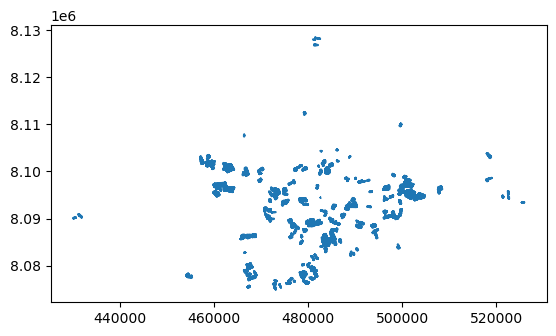

In [15]:
gdf_lineas.plot()

In [16]:
len(gdf_lineas)

598

In [17]:
gdf_lineas.to_file('capa_kml_todo', driver="ESRI Shapefile")